<a href="https://colab.research.google.com/github/sameepshrestha/segmentation_state_of_the_art/blob/main/model_with_skip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.4.1
import tensorflow
print(tensorflow.__version__)

2.4.1


In [2]:
# model.summary()
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import matplotlib.pyplot as plt 
import numpy as np 
import cv2 as cv 
from PIL import Image, ImageDraw
import json 
import os 
import glob 
import re 
from tqdm import tqdm
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Reshape, Concatenate,MaxPooling2D, AveragePooling2D,Input, BatchNormalization, Activation, UpSampling2D, Concatenate, LeakyReLU,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D,Multiply,SpatialDropout2D,Add
from tensorflow.keras.optimizers import Adam 
#using tensorflow backend 16 so keras backend still 32bytes so no keras to be used
# from keras.layers.merge import concatenate,Concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import gc
import psutil

In [4]:
tf.keras.mixed_precision.experimental.set_policy('mixed_float16')
# # tf.compat.v1.disable_eager_execution()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [5]:
category = """wall, floor, cabinet, bed, chair, sofa, table, door, window, bookshelf, picture, counter, blinds, desk, shelves, curtain, dresser
, pillow, mirror, floor mat, clothes, ceiling, books, fridge, tv, paper, towel, shower curtain, box, whiteboard, person, nightstand, toilet, sink
, lamp, bathtub, bag"""
category = category.split(r', ')
category = [i.replace('\n','') for i in category]
category_1 = ['background']
for categ in category:category_1.append(categ) 
category_dict = {k:category_1.index(k) for k in category_1}
reverse_map={i:k for k,i in category_dict.items()}
color_list=['gray','red','green','#FFFF00','#8c564b','#4B8BBE','#306998','#FFE873','#FFD43B','#646464','#5a0000','#003a27','#C0C0C0','#808080','#800000','#808000','#00FF00','#00FFFF','#008080','#000080','#FF00FF','#800080','#CD5C5C','#F08080','#FA8072','#E9967A','#FFA07A','#DC143C','#FF7F50','#FFD700','#ffffe0','#bdb76b','#228b22','#B0E0E6','#4169e1','#f0ffff','#d2691e','#BC8F8F']
class_color_map={k:color_list[i] for i,k in enumerate(reverse_map.keys())}

In [6]:
AUTO = tf.data.experimental.AUTOTUNE
Image_width = 640 
Image_height = 480 
no_classes = len(category_dict)
def load_data(path, split=0.2):
    images = sorted(glob.glob(os.path.join(path, "image/*")))
    print(len(images))
    masks = sorted(glob.glob(os.path.join(path, "mask2/*")))
    print(len(masks))
    total_size = 7990
    test_size = 1990
    valid_size=1000
    training_x, test_x = train_test_split(images[:7990], test_size=test_size, random_state=42)
    training_y, test_y = train_test_split(masks[:7990], test_size=test_size, random_state=42)
    train_x, valid_x = train_test_split(training_x, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(training_y, test_size=valid_size, random_state=42)
    return (train_x, train_y), (valid_x, valid_y),(test_x, test_y)
(train_x,train_y),(valid_x,valid_y),(test_x, test_y)=load_data('/content/drive/MyDrive/depth')
train_size=len(train_x)
valid_size=len(valid_x)

def read_image(path):
    path = path.decode()
    x = cv.imread(path, cv.IMREAD_COLOR)
    x = cv.resize(x,(640,480),interpolation=cv.INTER_AREA)
    x = x/255.0
    x=tf.cast(x,dtype=tf.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv.imread(path, cv.IMREAD_GRAYSCALE)
    x = cv.resize(x,(640,480),interpolation=cv.INTER_NEAREST)
  
    x = to_categorical(x,num_classes=no_classes)
    x = x[:,:,:]
    # x = np.expand_dims(x, axis=-1)
    # x=np.concatenate([x,x],axis=-1)
    x=tf.cast(x,dtype=tf.float32)
    return x
# read_mask('/content/drive/MyDrive/depth/mask100/mask1.png')
def parser(x,y):
    def _parse(x,y):
        x=read_image(x)
        y=read_mask(y)
        return x,y
    x,y = tf.numpy_function(_parse, [x,y], [tf.float32,tf.float32])
    x.set_shape([Image_height, Image_width, 3])
    y.set_shape([Image_height, Image_width, no_classes])
    return x,y
    
def tf_dataset(x, y, batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(parser)
    # dataset = dataset.cache()
    dataset = dataset.repeat()
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(AUTO)
    return dataset
train_dataset=tf_dataset(train_x,train_y,batch=16)
valid_dataset=tf_dataset(valid_x,valid_y,batch=16)
valid_dataset

8033
8033


<PrefetchDataset shapes: ((None, 480, 640, 3), (None, 480, 640, 38)), types: (tf.float32, tf.float32)>

In [7]:
print(test_x[:100])

['/content/drive/MyDrive/depth/image/image5457.jpg', '/content/drive/MyDrive/depth/image/image5917.jpg', '/content/drive/MyDrive/depth/image/image7738.jpg', '/content/drive/MyDrive/depth/image/image7847.jpg', '/content/drive/MyDrive/depth/image/image3387.jpg', '/content/drive/MyDrive/depth/image/image516.jpg', '/content/drive/MyDrive/depth/image/image1978.jpg', '/content/drive/MyDrive/depth/image/image4452.jpg', '/content/drive/MyDrive/depth/image/image470.jpg', '/content/drive/MyDrive/depth/image/image2603.jpg', '/content/drive/MyDrive/depth/image/image3895.jpg', '/content/drive/MyDrive/depth/image/image5776.jpg', '/content/drive/MyDrive/depth/image/image164.jpg', '/content/drive/MyDrive/depth/image/image7588.jpg', '/content/drive/MyDrive/depth/image/image5720.jpg', '/content/drive/MyDrive/depth/image/image2827.jpg', '/content/drive/MyDrive/depth/image/image1903.jpg', '/content/drive/MyDrive/depth/image/image5203.jpg', '/content/drive/MyDrive/depth/image/image2773.jpg', '/content/driv

In [8]:
#changes 
#Added a extra convolution in the encoder part lets look if it makes improvement or not 
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    filters = init.shape[-1]
    se_shape = (1, 1, filters)
    se = GlobalAveragePooling2D()(inputs)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    print(se.shape)
    return se
    
def experiment2(inputs,filters):
  x = Conv2D(filters, (3, 3), padding="same",kernel_initializer='he_normal')(inputs)
  x = SpatialDropout2D(0.1)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.001)(x)
  x = Conv2D(filters, (3, 3), padding="same",kernel_initializer='he_normal')(x)
  x = SpatialDropout2D(0.1)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.001)(x)
  x = Conv2D(1, (1, 1), padding="same",kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.001)(x)
  return x 

def encoder_conv_block(inputs,filters):
  x = Conv2D(filters, (3, 3), padding="same",kernel_initializer='he_normal')(inputs)
  x = SpatialDropout2D(0.1)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.001)(x)
  x = Conv2D(filters, (3, 3), padding="same",kernel_initializer='he_normal')(x)
  x = SpatialDropout2D(0.1)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.001)(x)
#   x =  squeeze_excite_block(x)
  return x 

def decoder_conv_block(inputs,filters1,filters2):
  x = Conv2D(filters1, (3, 3), padding="same",kernel_initializer='he_normal')(inputs)
  x = SpatialDropout2D(0.1)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.001)(x)
  x = Conv2D(filters2, (3, 3), padding="same",kernel_initializer='he_normal')(x)
  x = SpatialDropout2D(0.1)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.001)(x)
  return x

def encoder(inputs):
  num_filters = [32,64, 128,256,256]
  x= inputs
  skip_add= []
  skip_multiply = []
  for i,filters  in enumerate(num_filters):
    x = encoder_conv_block(x,filters)

    if i in [1,2,3,4]:
      added_layer = experiment2(x,filters)
      added_layer2 = squeeze_excite_block(x)
      skip_add.append(added_layer)
      skip_multiply.append(added_layer2)
    x = MaxPooling2D((2, 2))(x)
  return x ,skip_add,skip_multiply

def decoder(x,skip_add,skip_multiply):
  skip_add.reverse()
  skip_multiply.reverse()
  num_filters = [32,64, 128,256,256,512]
  num_filters.reverse()
  for i in range(len(num_filters)-1):
    x = decoder_conv_block(x,num_filters[i],num_filters[i+1])
    x = UpSampling2D((2,2))(x)
    if i in [0,1, 2,3]:
      print(skip_multiply[i].shape,skip_add[i])
      print(x.shape)
      x= Multiply()([x,skip_multiply[i]])
      x= Add()([x,skip_add[i]])
  return x
def output_block(inputs,classes):
    x = Conv2D(classes,(1, 1), padding="same")(inputs)
    return x
def main_model(shape):
  inputs = Input(shape)
  encoded,skip_add,skip_multiply = encoder(inputs)
  print(len(skip_add))
  print(len(skip_multiply))

  decoded = decoder(encoded,skip_add,skip_multiply)
  output = output_block(decoded,classes=38)
  model = Model(inputs,output)
  return model

model = main_model((480,640,3))

(None, 1, 1, 64)
(None, 1, 1, 128)
(None, 1, 1, 256)
(None, 1, 1, 256)
4
4
(None, 1, 1, 256) KerasTensor(type_spec=TensorSpec(shape=(None, 30, 40, 1), dtype=tf.float16, name=None), name='leaky_re_lu_21/LeakyRelu:0', description="created by layer 'leaky_re_lu_21'")
(None, 30, 40, 256)
(None, 1, 1, 256) KerasTensor(type_spec=TensorSpec(shape=(None, 60, 80, 1), dtype=tf.float16, name=None), name='leaky_re_lu_16/LeakyRelu:0', description="created by layer 'leaky_re_lu_16'")
(None, 60, 80, 256)
(None, 1, 1, 128) KerasTensor(type_spec=TensorSpec(shape=(None, 120, 160, 1), dtype=tf.float16, name=None), name='leaky_re_lu_11/LeakyRelu:0', description="created by layer 'leaky_re_lu_11'")
(None, 120, 160, 128)
(None, 1, 1, 64) KerasTensor(type_spec=TensorSpec(shape=(None, 240, 320, 1), dtype=tf.float16, name=None), name='leaky_re_lu_6/LeakyRelu:0', description="created by layer 'leaky_re_lu_6'")
(None, 240, 320, 64)


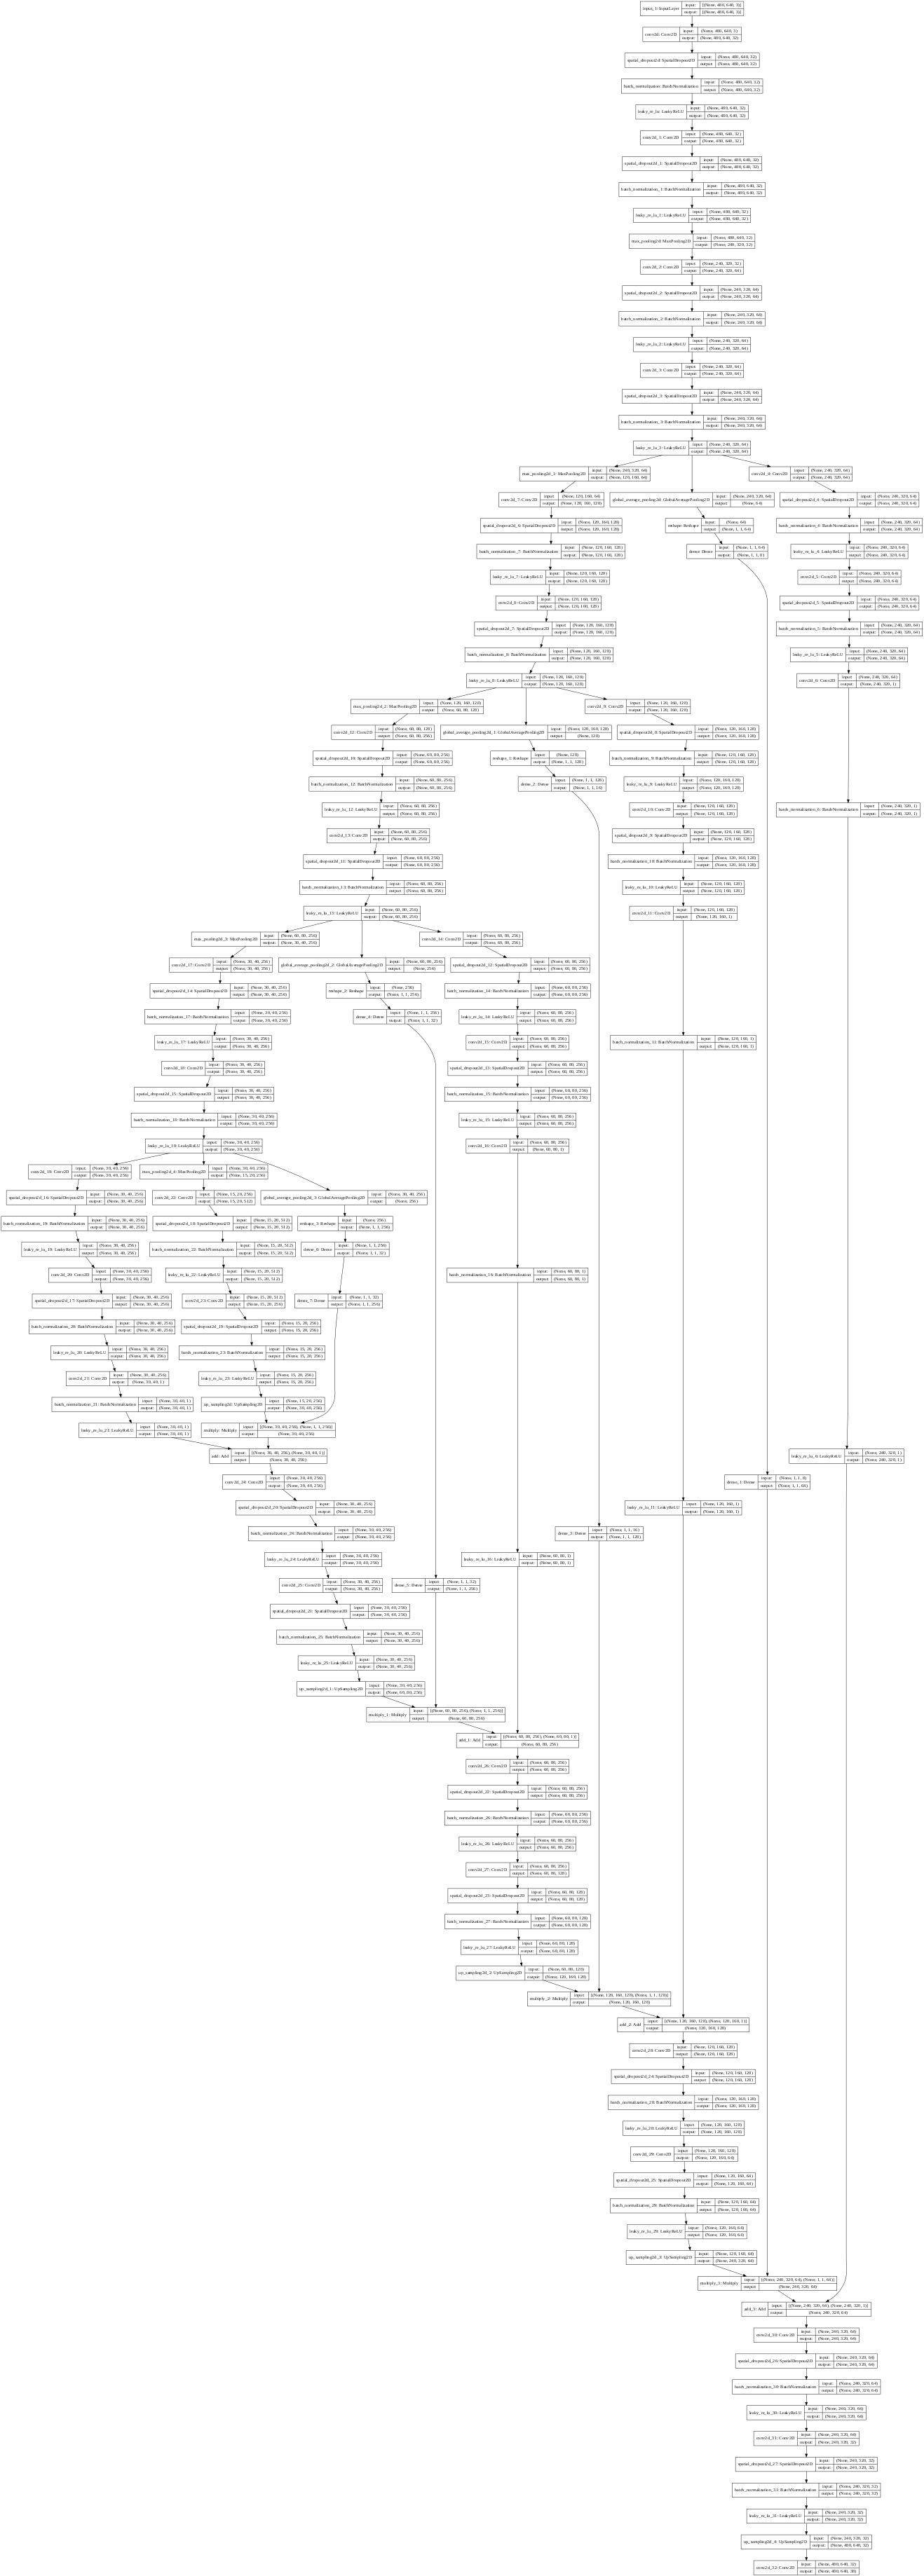

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=32)

In [10]:
#loss function 

import gc 
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger ,LearningRateScheduler,Callback

def binary_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred,from_logits=True)
    loss_value = tf.math.reduce_mean(loss,axis=[0])
    return loss_value
def cross_entropy_loss(y_true,y_pred):
    loss = tf.nn.softmax_cross_entropy_with_logits(
    y_true, y_pred, axis=-1, name=None)
    return loss

def custom_metrics(y_true,y_pred,smooth=1):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    # y_pred = tf.expand_dims(y_pred,axis=-1)
    y_pred = tf.one_hot(y_pred,38)
    y_true = y_true[:,:,:,1:38]
    y_pred= y_pred[:,:,:,1:38]
    intersection  = tf.math.reduce_sum((y_true*y_pred),axis = [1,2,3])
    union = (tf.math.reduce_sum(y_true,axis=[1,2,3])+tf.math.reduce_sum(y_pred,axis = [1,2,3])) - intersection
    return tf.math.reduce_mean((intersection+smooth)/(union+smooth),axis=0)
smooth = 1
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
model=tf.keras.models.load_model('/content/drive/MyDrive/new_architecture/skip_layers-june22/',custom_objects={'cross_entropy_loss': cross_entropy_loss ,'dice_coef': dice_coef,'custom_metrics':custom_metrics})
model.compile(loss = cross_entropy_loss,optimizer=Adam(learning_rate =.001),metrics=[custom_metrics])

In [ ]:
epoch=30
# model.save('/content/drive/MyDrive/new_architecture/model_normal-june22/',save_format='tf')
t_steps=train_size//16
v_steps=valid_size//16
val_custom_metrics = 0
for i in range(epoch):
  print('epoch =',i)
  model.fit(train_dataset,epochs= 1,steps_per_epoch=t_steps)
  loss = model.evaluate(valid_dataset,steps=v_steps)
  if loss[1]>=val_custom_metrics:
    val_custom_metrics = loss[1]
    model.save('/content/drive/MyDrive/new_architecture/skip_layers-june22/',save_format='tf')
  tf.keras.backend.clear_session()
  gc.collect()

epoch = 0
62/62 [==============================] - 82s 1s/step - loss: 1.7500 - custom_metrics: 0.2929
INFO:tensorflow:Assets written to: /content/drive/MyDrive/new_architecture/skip_layers-june22/assets
epoch = 1
62/62 [==============================] - 82s 1s/step - loss: 1.7161 - custom_metrics: 0.2901
epoch = 2
62/62 [==============================] - 81s 1s/step - loss: 1.7209 - custom_metrics: 0.3015
INFO:tensorflow:Assets written to: /content/drive/MyDrive/new_architecture/skip_layers-june22/assets
epoch = 3
62/62 [==============================] - 81s 1s/step - loss: 1.7059 - custom_metrics: 0.3071
INFO:tensorflow:Assets written to: /content/drive/MyDrive/new_architecture/skip_layers-june22/assets
epoch = 4
62/62 [==============================] - 82s 1s/step - loss: 1.7003 - custom_metrics: 0.3046
epoch = 5
62/62 [==============================] - 81s 1s/step - loss: 1.6615 - custom_metrics: 0.2969
epoch = 6
62/62 [==============================] - 82s 1s/step - loss: 1.6541 -